In [1]:
using NeuralPDE, Flux, ModelingToolkit, GalacticOptim, Optim, DiffEqFlux

In [18]:
using Flux

using DiffEqFlux

using ModelingToolkit
#using DiffEqBase
using  NeuralPDE

using GalacticOptim
using Optim
using Quadrature, Cubature, Cuba
#using Cubature, Cuba

In [20]:
@parameters x, t
@variables u(..)
@derivatives Dxx''~x
@derivatives Dtt''~t
@derivatives Dt'~t

#2D PDE
C=1
eq  = Dtt(u(x,t)) ~ C^2*Dxx(u(x,t))

# Initial and boundary conditions
bcs = [u(0,t) ~ 0.,# for all t > 0
       u(1,t) ~ 0.,# for all t > 0
       u(x,0) ~ x*(1. - x), #for all 0 < x < 1
       Dt(u(x,0)) ~ 0. ] #for all  0 < x < 1]

# Space and time domains
domains = [x ∈ IntervalDomain(0.0,1.0),
           t ∈ IntervalDomain(0.0,1.0)]
# Discretization
dx = 0.1

# Neural network
chain = FastChain(FastDense(2,16,Flux.σ),FastDense(16,16,Flux.σ),FastDense(16,1))

phi = NeuralPDE.get_phi(chain)
derivative = NeuralPDE.get_derivative(false)
initθ = DiffEqFlux.initial_params(chain)

indvars = [x,t]
depvars = [u]
dim = length(domains)

_pde_loss_function = NeuralPDE.build_loss_function(eq,indvars,depvars,phi, derivative)

bc_indvars = NeuralPDE.get_bc_varibles(bcs,indvars,depvars)
_bc_loss_functions = [NeuralPDE.build_loss_function(bc,indvars,depvars, phi, derivative,
                                              bc_indvars = bc_indvar) for (bc,bc_indvar) in zip(bcs,bc_indvars)]

train_sets = NeuralPDE.generate_training_sets(domains,dx,bcs,indvars,depvars)
pde_train_set,bcs_train_set,train_set = train_sets

pde_bounds, bcs_bounds = NeuralPDE.get_bounds(domains,bcs,indvars,depvars)
grid_strategy = NeuralPDE.GridTraining(dx=dx)
quadrature_strategy = NeuralPDE.QuadratureTraining(algorithm=HCubatureJL(),reltol= 1e-2,abstol= 1e-2,maxiters=10)
pde_loss_function = NeuralPDE.get_loss_function(_pde_loss_function,
                                                pde_bounds,
                                                quadrature_strategy)

bc_loss_function = NeuralPDE.get_loss_function(_bc_loss_functions,
                                               bcs_bounds,
                                               quadrature_strategy)

function loss_function(θ,p)
    return pde_loss_function(θ) + bc_loss_function(θ)
end

f = OptimizationFunction(loss_function, GalacticOptim.AutoZygote())
prob = GalacticOptim.OptimizationProblem(f, initθ)

cb = function (p,l)
    println("Current loss is: $l")
    return false
end

res = GalacticOptim.solve(prob,Optim.BFGS(); cb = cb, maxiters=400)

xs,ts = [domain.domain.lower:dx:domain.domain.upper for domain in domains]
analytic_sol_func(x,t) =  sum([(8/(k^3*pi^3)) * sin(k*pi*x)*cos(C*k*pi*t) for k in 1:2:50000])

u_predict = reshape([first(phi([x,t],res.minimizer)) for x in xs for t in ts],(length(xs),length(ts)))
u_real = reshape([analytic_sol_func(x,t) for x in xs for t in ts], (length(xs),length(ts)))

Current loss is: 0.03083993272155988
Current loss is: 0.0008285441055129282
Current loss is: 0.0008263571983272946
Current loss is: 0.0005524678713309957
Current loss is: 0.0005454790812879629
Current loss is: 0.000545031391910622
Current loss is: 0.0005450267815214609
Current loss is: 0.0005449946840529703
Current loss is: 0.0005445176119535194
Current loss is: 0.0005445166090098479
Current loss is: 0.0005431478000810717
Current loss is: 0.000539673091240457
Current loss is: 0.0005387490372788369
Current loss is: 0.0005377987115638517
Current loss is: 0.000535821622959382
Current loss is: 0.0005357032199186683
Current loss is: 0.000534053320759699
Current loss is: 0.0005334014699556023
Current loss is: 0.0005320818852509844
Current loss is: 0.000529919975932347
Current loss is: 0.000521044013940342
Current loss is: 0.000515008768939892
Current loss is: 0.0005144176801000903
Current loss is: 0.0005117293154951424
Current loss is: 0.0005098647265362853
Current loss is: 0.000508135783210

11×11 Array{Float64,2}:
 0.0   0.09          0.16          0.21         …   0.09          3.94548e-17
 0.0   0.08          0.15          0.2              0.08          3.07758e-17
 0.0   0.06          0.12          0.17             0.06          2.39622e-17
 0.0   0.04          0.08          0.12             0.04          1.49581e-17
 0.0   0.02          0.04          0.06             0.02          8.68417e-18
 0.0   4.34208e-18   7.47903e-18   1.19811e-17  …   4.34208e-18  -1.96619e-33
 0.0  -0.02         -0.04         -0.06            -0.02         -8.68417e-18
 0.0  -0.04         -0.08         -0.12            -0.04         -1.49581e-17
 0.0  -0.06         -0.12         -0.17            -0.06         -2.39622e-17
 0.0  -0.08         -0.15         -0.2             -0.08         -3.07758e-17
 0.0  -0.09         -0.16         -0.21         …  -0.09         -3.94548e-17

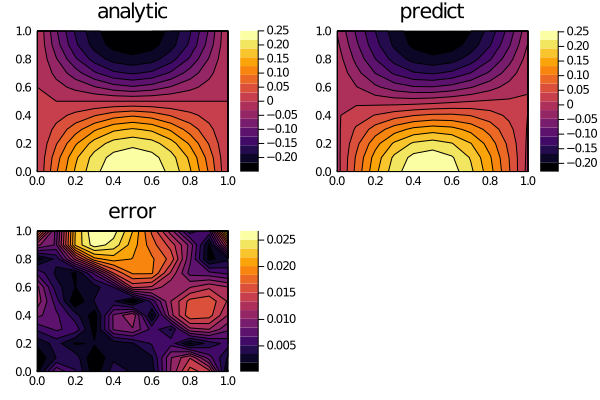

In [22]:
using Plots
diff_u = abs.(u_predict .- u_real)
p1 = plot(xs, ts, u_real, linetype=:contourf,title = "analytic");
p2 =plot(xs, ts, u_predict, linetype=:contourf,title = "predict");
p3 = plot(xs, ts, diff_u,linetype=:contourf,title = "error");
plot(p1,p2,p3)